# Dealing with olympic data
We are going to use ujson to import the data, because 
- The data is a multilevel table stored inside a json file, Panda isn't equip with dealing with this kind of table. 
- The file is large, if you are using the built-in lib of python it will take up like 3-4 gb ram and a long time to load, slow reading speed
## Import libaries

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import ujson as json
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# you can download the dataset from here https://www.kaggle.com/datasets/llui85/tokyo-2021-olympics-complete-grouped-by-type
with open("input_your_path_to_the_data_file_here/tokyo-olympics-all-by-type-2021-08-11.json", 'r') as file:
    olympicsData = json.load(file)

## Get the fields and keys of the dataset

Get the list of keys from the dataset

In [8]:
for k,v in olympicsData.items():
    print(k)

Aggregate
Ceremony
Competitor
Discipline
Event
EventUnit
Individual
MedalCount
Medal
Organisation
Participant
Phase
Result
ScheduleItem
ScheduleSession
Stage
SubEventUnit
Venue


Get the heading of each keys of each id in the table

In [9]:
for k,v in olympicsData.items():
    print(k)
    for k,v in v.items():
        print(k)
        # print(v["id"])
        # you can access the id of a element in 2 ways 
        print(v.keys())
        break

Aggregate
00958790-b0ec-417a-a5f3-a034ed8f75ba
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Ceremony
75cda579-afa5-47fa-9e68-3e7ed3fa99d0
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Competitor
000073da-33b7-34b2-b993-54d8db734450
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Discipline
00e2cff7-ab78-311d-8e14-079dec40050a
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Event
01686c03-bb3b-3f76-9569-32f1799f2cdc
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
EventUnit
0008b366-4f7c-3f11-82b7-f71987038e0c
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Individual
00036aa4-254a-32dd-8f3f-b42938331416
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
MedalCount
000e4fd3-a8bb-4247-9a32-c5264584b259
dict_keys(['attributes', 'id', 'links', 'relationships', 'type'])
Medal
0049b4b2-113f-3754-ba83-63bd582f02c8
dict_keys(['attributes', 'id', 'links', 'relationships

Get the ID of each sports

In [ ]:
disciplines = olympicsData["Discipline"]
events = olympicsData["Event"]
finalData = []

for itemId, item in events.items():
    disciplineId = item["relationships"]["discipline"]["data"]["id"]
    discipline = disciplines[disciplineId]
    finalData.append({
        "name": item["attributes"]["name"],
        "id": item["attributes"]["externalId"],
        "disciplineName": discipline["attributes"]["name"]
    })
    
print(json.dumps(finalData, indent=4))

Get the attributes of each keys in the table

In [ ]:
for id,content in olympicsData.items():
    print(id)
    for k,v in content.items():
        print(v["attributes"].keys())
        break

See a list of participants

In [ ]:
for k,v in olympicsData["Individual"].items():
    if v["attributes"]["name"] is not None:
        print(v["attributes"]["name"])

Get the relationships between each keys in the dataset

In [16]:
for id,content in olympicsData.items():
    print(id)
    for k,v in content.items():
        print(v["relationships"].keys())
        break

Aggregate
dict_keys(['discipline', 'organisation', 'tags'])
Ceremony
dict_keys(['pictogram'])
Competitor
dict_keys(['event', 'eventUnit', 'medals', 'participant', 'phase', 'results', 'scheduleSession', 'stage', 'subEventUnit'])
Discipline
dict_keys(['events', 'organisations', 'participants', 'pictogram', 'scheduleSessions', 'thumbnail'])
Event
dict_keys(['competitors', 'discipline', 'medals', 'stages'])
EventUnit
dict_keys(['competitors', 'highlightVod', 'medals', 'phase', 'results', 'scheduleItems', 'subEventUnits', 'venue'])
Individual
dict_keys(['participants', 'profileImage', 'thumbnail'])
MedalCount
dict_keys(['discipline', 'organisation'])
Medal
dict_keys(['competitor', 'discipline', 'event', 'eventUnit', 'organisation', 'participant', 'subEventUnit'])
Organisation
dict_keys(['country', 'flag', 'medalCounts', 'participants'])
Participant
dict_keys(['children', 'competitors', 'discipline', 'individual', 'organisation', 'parents'])
Phase
dict_keys(['competitors', 'eventUnits', 'hig

## Create a function from the code used to get the results of participants using the External ID of a sport

*Note regarding participants: A participant is considered to be any individual (type athlete, participating or not in the current games) or any official in one or several disciplines or a competitor being part of a team (team member). A competitor is one person who is competing in a particular event.*

The value field is partial for a FRAME_RESULT, only providing the time change since the previous frame was sent.
The final official times are stored in results that satisfy resultType == STRUCTURED_RESULT && status == OFFICIAL. These results include summaries of the frame results in extendedInfo.odfExtensions, as well as final ranks and DNF statuses.

In [15]:
def get_result(sportExternalId):
    Data = []
    for itemId, item in olympicsData["EventUnit"].items():
        if sportExternalId[0:9] in item["attributes"]["externalId"]:
            resultIDs = item["relationships"]["results"]["data"] 
            # One event unit will have multiple results because there are multiple participants and each participants will have multiple results as results are recorded in lapses or frames
            # So the data will be return as a list
            for resultID in resultIDs: #Loop through the list
                resultID = resultID["id"] #Get the id of one single result
                competitorID = olympicsData["Result"][resultID]["relationships"]['competitor']["data"]["id"] 
                # Get the id of the person/competitor owns this particular result in this particular event
                participantID = olympicsData["Competitor"][competitorID]["relationships"]["participant"]["data"]["id"]
                # Using the competitorID of a person to find their participantID to find out more about them
                resultType = olympicsData["Result"][resultID]["attributes"]["resultType"]
                if "FRAME_RESULT" in resultType:
                    continue
                Data.append({
                "eventTile": item["attributes"]["title"],
                "value": olympicsData["Result"][resultID]["attributes"]["value"],
                "participantName": olympicsData["Participant"][participantID]["attributes"]["name"], # Get the participant's name using participantID
                "resultType": olympicsData["Result"][resultID]["attributes"]["resultType"],
                "resultStatus": olympicsData["Result"][resultID]["attributes"]["status"]
                })
    return Data
    

Get data from sports that have a single value as the end result like running, swimming, weightlifting for easy comparsion
1. Get the list of externalID of these sports and store in a list ```SportsData```

In [16]:
disciplines = olympicsData["Discipline"]
events = olympicsData["Event"]
SportsData = []
for itemId, item in events.items():
    disciplineId = item["relationships"]["discipline"]["data"]["id"]
    discipline = disciplines[disciplineId]
    if discipline["attributes"]["name"] in ["Athletics","Swimming","Weightlifting"]:
        SportsData.append({
            "name": item["attributes"]["name"],
            "id": item["attributes"]["externalId"],
            "disciplineName": discipline["attributes"]["name"]
        })

2. Get the data of ```SportsData``` using the ```get_result``` function created above

In [ ]:
finalData = {}
for sport in SportsData:
    if  "Decathlon" in sport["name"] or "Heptathlon" in sport["name"]:
        continue
    finalData.update({
    sport["name"]:{
        "disciplineName": sport["disciplineName"],
        "resultData": get_result(sport["id"])
    }})
    # print(json.dumps(finalData,indent=4)) uncomment this line if you want to check out the result

Get the best performances of each athelete in each events(because if the athlete is good, they may not show their best performance/put in maximum effort on the outter round but the same can't hold truth for worse athlete)
We are gonna sort the list by values and drop rows where participantName have appeared already. This is and the fact that ```drop_duplicates``` is faster than ```unique``` are the reasons why we are going to use ```drop_duplicates``` instead ```unique```

In [18]:
import re
for sportName in finalData.keys():
    if re.search("\d+.m",sportName) is not None or "Marathon" in sportName: #Check for sport related to running when smaller value is better
        finalData[sportName]["resultData"] = pd.DataFrame(finalData[sportName]["resultData"]).sort_values(by="value",ascending=True).drop_duplicates(subset=['participantName'],keep='first')
    else:
        finalData[sportName]["resultData"] = pd.DataFrame(finalData[sportName]["resultData"]).sort_values(by="value",ascending=False).drop_duplicates(subset=['participantName'],keep='first')

In [19]:
for sportName in finalData.keys():
    finalData[sportName]["resultData"] .dropna(inplace=True)
    
for sportName in finalData.keys():
    df = finalData[sportName]["resultData"]
    finalData[sportName]["resultData"] = df[~df['value'].isin(['-'])]

In [20]:
def cal_relative_mean_absolute_difference(values):
    meanAbsoluteDifference = np.mean(np.absolute(values-np.mean(values)))
    relativeMeanAbsoluteDifference = meanAbsoluteDifference/stat.mean(values)
    return relativeMeanAbsoluteDifference

def cal_index_of_dispersion(values):
    indexOfDispersion = stat.variance(values)/stat.mean(values)
    return indexOfDispersion

<Axes: xlabel='Variance-to-mean ratio', ylabel='Relative mean absolute difference'>

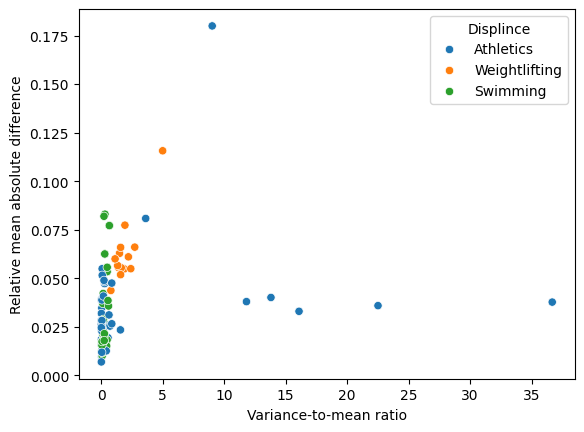

In [21]:
scatterPlotData = []
for sport in finalData:
    values = []
    if re.search("\d+.m",sport) is not None or "Marathon" in sport:#Check for if the sport's score is neasured in times
        for value in finalData[sport]["resultData"]["value"]:
            list = value.split(":")
            a = 0
            for i in range(len(list)):
                a = a + float(list[i]) * (60 ** (len(list)-i-1))
            values.append(a)
    else:
        values = finalData[sport]["resultData"]["value"].astype("float")
    indexOfDispersion = cal_index_of_dispersion(values)
    relativeMeanAbsoluteDifference = cal_relative_mean_absolute_difference(values)
    scatterPlotData.append({
        "Variance-to-mean ratio":indexOfDispersion,
        "Relative mean absolute difference":relativeMeanAbsoluteDifference,
        "Displince": finalData[sport]["disciplineName"],
        "Name": str(sport)
        })
scatterPlotData = pd.DataFrame(scatterPlotData)
sns.scatterplot(data=scatterPlotData,x = 'Variance-to-mean ratio',y = 'Relative mean absolute difference',hue = "Displince")

<Axes: xlabel='Relative mean absolute difference'>

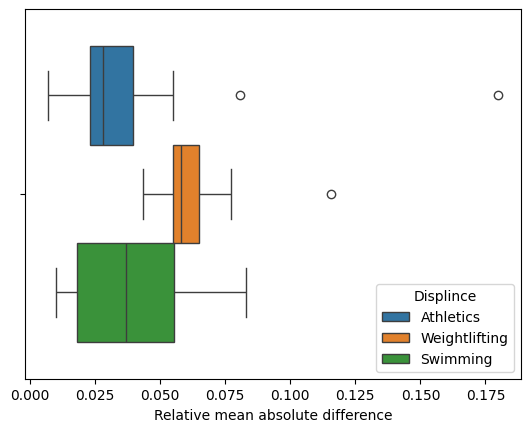

In [ ]:
sns.boxplot(data=scatterPlotData,x = 'Relative mean absolute difference',hue="Displince")